#Simulation Analysis

In [1]:
from __future__ import print_function, division
#add project directory to python path
import sys
sys.path.append("..")
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from default import PROJECT_DIRECTORY, DATA_DIRECTORY

##Load Simulation

In [2]:
"""
load halo catalogue to populate for mocks
"""
from halotools import sim_manager
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol=0.001,
                                        version_name='custom', halo_finder='Rockstar')

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')


In [59]:
"""
load supplemtary halo catalogue properties
"""
from astropy.table import Table

filepath = DATA_DIRECTORY
add_halo_props = Table.read(filepath+"bolshoi_additional_halo_properties.hdf5", path='data')
print(add_halo_props.dtype.names)

('halo_id', 'halo_mpeak', 'halo_mpeak_scale', 'halo_mpeak_prime', 'halo_mpeak_prime_scale', 'halo_0.1_mpeak_scale', 'halo_0.2_mpeak_scale', 'halo_0.3_mpeak_scale', 'halo_0.4_mpeak_scale', 'halo_0.5_mpeak_scale', 'halo_0.6_mpeak_scale', 'halo_0.7_mpeak_scale', 'halo_0.8_mpeak_scale', 'halo_0.9_mpeak_scale', 'halo_0.1_mpeak_prime_scale', 'halo_0.2_mpeak_prime_scale', 'halo_0.3_mpeak_prime_scale', 'halo_0.4_mpeak_prime_scale', 'halo_0.5_mpeak_prime_scale', 'halo_0.6_mpeak_prime_scale', 'halo_0.7_mpeak_prime_scale', 'halo_0.8_mpeak_prime_scale', 'halo_0.9_mpeak_prime_scale', 'halo_acc_scale_1', 'halo_acc_scale_2', 'halo_acc_scale_3', 'halo_acc_scale_4', 'halo_acc_scale_5', 'halo_acc_scale_6', 'halo_acc_scale_7', 'halo_acc_scale_8', 'halo_acc_scale_9', 'halo_acc_scale_10', 'halo_ejt_scale_1', 'halo_ejt_scale_2', 'halo_ejt_scale_3', 'halo_ejt_scale_4', 'halo_ejt_scale_5', 'halo_ejt_scale_6', 'halo_ejt_scale_7', 'halo_ejt_scale_8', 'halo_ejt_scale_9', 'halo_ejt_scale_10', 'halo_last_acc_scale

In [60]:
#replace with some halo properties custom properties
halocat.halo_table['halo_mpeak'] = add_halo_props['halo_mpeak_prime']
halocat.halo_table['halo_acc_scale'] = add_halo_props['halo_prime_acc_scale_2']
halocat.halo_table['halo_mpeak_scale'] = add_halo_props['halo_mpeak_prime_scale']

In [61]:
#clear up some memory
add_halo_props = 0.0

##Extrapolate sub-halo masses

In [115]:
"""
use MAHs to extrapolate sub-halo masses past z_acc
"""

from Halo_model_components import Continued_Growth

mass_growth_model = Continued_Growth(cosmo=cosmo)

m = halocat.halo_table['halo_mpeak']
a = halocat.halo_table['halo_acc_scale']
sub = (halocat.halo_table['halo_upid']!=-1)

#set host-halo masses to current peak mass
halocat.halo_table['halo_m_extrap_4gyr'] = m
halocat.halo_table['halo_m_extrap_14gyr'] = m
halocat.halo_table['halo_acc_scale_extrap_4gyr'] = a
halocat.halo_table['halo_acc_scale_extrap_14gyr'] = a

#extrapolate sub-halo masses past z_acc
m = halocat.halo_table['halo_macc']
dum, dum, a4, m4 = mass_growth_model.extrapolate_mass(m[sub], a[sub], 4)
dum, dum, a14, m14 = mass_growth_model.extrapolate_mass(m[sub], a[sub], 14)

#set new extrapolated mass
halocat.halo_table['halo_m_extrap_4gyr'][sub] = m4
halocat.halo_table['halo_m_extrap_14gyr'][sub] = m14

#get scale factor of extrapolation
halocat.halo_table['halo_acc_scale_extrap_4gyr'][sub] = a4
halocat.halo_table['halo_acc_scale_extrap_14gyr'][sub] = a14

In [116]:
"""
convert halo masses from 360b to the definitons used in Y12 and B13
"""

from cosmo_utils import halo_mass_conversion

m180b = halo_mass_conversion(halocat.halo_table['halo_mpeak'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=180,
                             cosmo=cosmo, wrt_h='background', wrt_new='background')
m200c = halo_mass_conversion(halocat.halo_table['halo_mpeak'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=200,
                             cosmo=cosmo, wrt_h='background',
                             wrt_new='critical')

halocat.halo_table['halo_mpeak200c'] = m200c
halocat.halo_table['halo_mpeak180b'] = m180b


m180b = halo_mass_conversion(halocat.halo_table['halo_m_extrap_4gyr'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=180,
                             cosmo=cosmo, wrt_h='background', wrt_new='background')
m200c = halo_mass_conversion(halocat.halo_table['halo_m_extrap_4gyr'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=200,
                             cosmo=cosmo, wrt_h='background',
                             wrt_new='critical')

halocat.halo_table['halo_m_extrap_4gyr_200c'] = m200c
halocat.halo_table['halo_m_extrap_4gyr_180b'] = m180b

m180b = halo_mass_conversion(halocat.halo_table['halo_m_extrap_14gyr'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=180,
                             cosmo=cosmo, wrt_h='background', wrt_new='background')
m200c = halo_mass_conversion(halocat.halo_table['halo_m_extrap_14gyr'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=200,
                             cosmo=cosmo, wrt_h='background',
                             wrt_new='critical')

halocat.halo_table['halo_m_extrap_14gyr_200c'] = m200c
halocat.halo_table['halo_m_extrap_14gyr_180b'] = m180b

##Define SHAM Models

In [20]:
from halotools.empirical_models import SubhaloModelFactory
from default import additional_halo_properties, galaxy_selection_func

###RM Model w/ sat growth

In [26]:
from SHAM_model_components import RankSmHm

prim_haloprop_key = 'halo_mpeak'
mstar_model = RankSmHm(prim_haloprop_key=prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1a = SubhaloModelFactory(stellar_mass = mstar_model, 
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_1a.param_dict['log_scatter'] = 0.0


prim_haloprop_key = 'halo_m_extrap_4gyr'
mstar_model = RankSmHm(prim_haloprop_key=prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1b = SubhaloModelFactory(stellar_mass = mstar_model, 
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_1b.param_dict['log_scatter'] = 0.0

prim_haloprop_key = 'halo_m_extrap_14gyr'
mstar_model = RankSmHm(prim_haloprop_key=prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1c = SubhaloModelFactory(stellar_mass = mstar_model, 
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_1c.param_dict['log_scatter'] = 0.0

In [29]:
"""
populate RM mocks
"""

np.random.seed(42)

composite_model_1a.populate_mock(halocat = halocat)
mock_1a = composite_model_1a.mock.galaxy_table

composite_model_1b.populate_mock(halocat = halocat)
mock_1b = composite_model_1b.mock.galaxy_table

composite_model_1c.populate_mock(halocat = halocat)
mock_1c = composite_model_1c.mock.galaxy_table

print("number of galaxies in mock: ", len(mock_1a))
f_sat_1a = float(np.sum(mock_1a['halo_upid']!=-1))/len(mock_1a)
print("satellite fraction: ", f_sat_1a)

print("number of galaxies in mock: ", len(mock_1b))
f_sat_1b = float(np.sum(mock_1b['halo_upid']!=-1))/len(mock_1b)
print("satellite fraction: ", f_sat_1b)

print("number of galaxies in mock: ", len(mock_1c))
f_sat_1c = float(np.sum(mock_1c['halo_upid']!=-1))/len(mock_1c)
print("satellite fraction: ", f_sat_1c)

number of galaxies in mock:  290840
satellite fraction:  0.207963141246
number of galaxies in mock:  290739
satellite fraction:  0.269262121697
number of galaxies in mock:  290003
satellite fraction:  0.294959017665


###M13 Model w/ sat growth

In [100]:
from SMHM_model_components import MosterSmHm13, Guo_to_Blanton

prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_acc_scale'
mstar_model = MosterSmHm13(redshift=0.0,
                           prim_haloprop_key=prim_haloprop_key,
                           acc_scale_key=acc_scale_key)
mstar_conv = Guo_to_Blanton()
composite_model_3a = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        stellar_mass_conversion = mstar_conv,
                                        model_feature_calling_sequence = ('haloprops','stellar_mass','stellar_mass_conversion'))
composite_model_3a.param_dict['log_scatter'] =  0.18

prim_haloprop_key =  'halo_m_extrap_4gyr_200c'
acc_scale_key='halo_acc_scale_extrap_4gyr'
mstar_model = MosterSmHm13(redshift=0.0,
                           prim_haloprop_key=prim_haloprop_key,
                           acc_scale_key=acc_scale_key)
mstar_conv = Guo_to_Blanton()
composite_model_3b = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        stellar_mass_conversion = mstar_conv,
                                        model_feature_calling_sequence = ('haloprops','stellar_mass','stellar_mass_conversion'))
composite_model_3b.param_dict['log_scatter'] =  0.18

prim_haloprop_key =  'halo_m_extrap_14gyr_200c'
acc_scale_key='halo_acc_scale_extrap_14gyr'
mstar_model = MosterSmHm13(redshift=0.0,
                           prim_haloprop_key=prim_haloprop_key,
                           acc_scale_key=acc_scale_key)
mstar_conv = Guo_to_Blanton()
composite_model_3c = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        stellar_mass_conversion = mstar_conv,
                                        model_feature_calling_sequence = ('haloprops','stellar_mass','stellar_mass_conversion'))
composite_model_3c.param_dict['log_scatter'] =  0.18

In [117]:
"""
populate M13 mocks
"""

np.random.seed(42)

composite_model_3a.populate_mock(halocat = halocat)
mock_3a = composite_model_3a.mock.galaxy_table

composite_model_3b.populate_mock(halocat = halocat)
mock_3b = composite_model_3b.mock.galaxy_table

composite_model_3c.populate_mock(halocat = halocat)
mock_3c = composite_model_3c.mock.galaxy_table

print("number of galaxies in mock: ", len(mock_3a))
f_sat_3a = float(np.sum(mock_3a['halo_upid']!=-1))/len(mock_3a)
print("satellite fraction: ", f_sat_3a)

print("number of galaxies in mock: ", len(mock_1b))
f_sat_3b = float(np.sum(mock_3b['halo_upid']!=-1))/len(mock_1b)
print("satellite fraction: ", f_sat_3b)

print("number of galaxies in mock: ", len(mock_3c))
f_sat_3c = float(np.sum(mock_3c['halo_upid']!=-1))/len(mock_3c)
print("satellite fraction: ", f_sat_3c)

number of galaxies in mock:  276879
satellite fraction:  0.164208914363
number of galaxies in mock:  290739
satellite fraction:  0.194380526864
number of galaxies in mock:  304948
satellite fraction:  0.224274302504


##Satellite Growth Models

Examine the Y12 and continued satellite growth models.

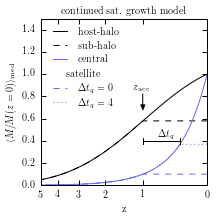

In [44]:
"""
make a visual diagram for the cotinued growth model using M13
"""

from Halo_model_components import MAH

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

p = MAH(cosmo)
mhalo_history, z_halo = p.mah(10**11.0, 1.0)

z_galaxy = z_halo
a_galaxy = 1.0/(1.0+z_galaxy)
mcen_history = composite_model_3a.mean_stellar_mass(prim_haloprop = 10**mhalo_history, halo_acc_scale=a_galaxy)

mask = z_halo < 1.0
i = find_nearest(z_halo,1.0)

msub_history = np.copy(mhalo_history)
msub_history[0][mask] = mhalo_history[0][i]
msat_history_1 = np.copy(mstar_history)
msat_history_1[0][mask] = mstar_history[0][i]

mask = z_halo < 0.342
i = find_nearest(z_halo,0.342)
msat_history_2 = np.copy(mstar_history)
msat_history_2[0][mask] = mstar_history[0][i]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.3, 3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
#host-halo
p1, = plt.plot(1+z_halo, 10**mhalo_history[0]/10**mhalo_history[0][0], color='black')
#sub-halo
p2, = plt.plot(1+z_halo, 10**msub_history[0]/10**mhalo_history[0][0], '--', color='black')
#satellite growth histories
p0, = plt.plot(1+z_halo, msat_history_1[0]/mcen_history[0][0], '-',color='white', alpha=0.0) #dummy
p3, = plt.plot(1+z_halo, mstar_history[0]/mstar_history[0][0], color='#6666ff')
p4, = plt.plot(1+z_halo, msat_history_1[0]/mstar_history[0][0], '--',color='#6666ff')
p5, = plt.plot(1+z_halo, msat_history_2[0]/mstar_history[0][0], ':',color='#6666ff')
plt.text(2.22,0.85,r'$z_{\rm acc}$', fontsize=10)
plt.arrow(2,0.825,dx=0.0,dy=-0.1, head_width=0.1, head_length=0.05, lw=0.5, color='black')
plt.plot([1+1.0,1+0.342],[0.4,0.4],'-',color='black')
plt.plot([1+1.0,1+1.0],[0.4-0.025,0.4+0.025],'-',color='black')
plt.plot([1+0.342,1+0.342],[0.4-0.025,0.4+0.025],'-',color='black')
plt.text(1+0.7,0.43,r'$\Delta t_{q}$')
plt.xlim([6,1])
plt.ylim([0,1.5])
plt.xscale('log')
plt.xlabel('z')
plt.xticks([6, 5, 4, 3, 2, 1])
ax.set_xticklabels(['5','4','3','2','1','0'])

#legend
plt.legend((p1,p2, p3, p0, p4, p5),('host-halo','sub-halo', 'central','', r'$\Delta t_{q}=0$',r'$\Delta t_{q}=4$'),
           fontsize=10, loc='upper left', frameon=False)
plt.ylabel(r'$\langle M/M(z=0) \rangle_{\rm med}$')
plt.text(4.6, 0.975, 'satellite', fontsize=10)
plt.title('continued sat. growth model')
plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'sat_growth_model_1'
fig.savefig(filepath+filename+'.pdf', dpi=300)

../SMHM_model_components.py:487: RuntimeWarning: overflow encountered in power
  numerator = (mass/m1)**(alpha+beta)
../SMHM_model_components.py:488: RuntimeWarning: overflow encountered in power
  denominator = (1.0+mass/m1)**beta
../SMHM_model_components.py:508: RuntimeWarning: overflow encountered in power
  numerator = (mass/m1)**(alpha+beta)
../SMHM_model_components.py:509: RuntimeWarning: overflow encountered in power
  denominator = (1.0+mass/m1)**beta


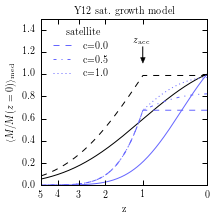

In [46]:
"""
make a visual for the Y12 satellite growth model
"""

from default import composite_model_4
from Halo_model_components import MAH

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

#get two halo growth histories
p = MAH(cosmo)
mhalo_history_1, z_halo = p.mah(10**11.0, 0.0)
mhalo_history_2, z_halo = p.mah(10**11.0, 1.0)
mhalo_history_1 = np.log10(10**mhalo_history_1*1.0)
mhalo_history_2 = np.log10(10**mhalo_history_2*0.96)

#cut off sub-halo growth
mask = (z_halo < 1.0)
i = find_nearest(z_halo,1.0)

msub_history = np.copy(mhalo_history_2)
msub_history[0][mask] = msub_history[0][i]

z_galaxy = z_halo
a_galaxy = 1.0/(1.0+z_galaxy)
a_sat = a_galaxy
a_sat[mask==True] = 1.0/(1.0+1.0)

mcen_history = composite_model_4.mean_stellar_mass(prim_haloprop = 10**mhalo_history_1,
                                                   halo_acc_scale = a_galaxy, redshift=z_galaxy)
composite_model_4.param_dict['c'] =  0.0
msat_history_1 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history,
                                                     halo_acc_scale = a_sat, redshift=z_galaxy)
composite_model_4.param_dict['c'] =  0.5
msat_history_2 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history,
                                                     halo_acc_scale = a_sat, redshift=z_galaxy)
composite_model_4.param_dict['c'] =  1.0
msat_history_3 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history,
                                                     halo_acc_scale = a_sat, redshift=z_galaxy)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.3, 3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
#host halo growth
p1, = plt.plot(1+z_halo, 10**mhalo_history_1[0]/10**mhalo_history_1[0][0], color='black')
#sub-halo growth
p2, = plt.plot(1+z_halo, 10**msub_history[0]/10**mhalo_history_1[0][0], '--', color='black')
#central galaxy growth
p3, = plt.plot(1+z_halo, mcen_history[0]/mcen_history[0][0], color='#6666ff')
#satellite growth models
p0, = plt.plot(1+z_halo, msat_history_1[0]/mcen_history[0][0], '-',color='white', alpha=0.0) #dummy
p4, = plt.plot(1+z_halo, msat_history_1[0]/mcen_history[0][0], '--',color='#6666ff')
p5, = plt.plot(1+z_halo, msat_history_2[0]/mcen_history[0][0], '-.',color='#6666ff')
p6, = plt.plot(1+z_halo, msat_history_3[0]/mcen_history[0][0], ':',color='#6666ff')

#accretion redshift label
plt.text(2.22,0.85+0.425,r'$z_{\rm acc}$', fontsize=10)
plt.arrow(2,0.825+0.425,dx=0.0,dy=-0.1, head_width=0.1, head_length=0.05, lw=0.5, color='black')
plt.xlim([6,1])
plt.ylim([0,1.5])
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\langle M/M(z=0) \rangle_{\rm med}$')
plt.xticks([6, 5, 4, 3, 2, 1])
ax.set_xticklabels(['5','4','3','2','1','0'])

#add legends
#plt.legend((p1,p2,p3,p0,p4,p5,p6),
#           ('host-halo','sub-halo','central','','c=0.0','c=0.5','c=1.0'),
#            frameon = False, fontsize=10, loc='upper left', handlelength=2.5)
plt.legend((p0,p4,p5,p6),
           ('','c=0.0','c=0.5','c=1.0'),
            frameon = False, fontsize=10, loc='upper left', handlelength=2.5)
#plt.text(4.6, 0.975, 'satellite', fontsize=10)
plt.text(4.6, 0.975+0.38, 'satellite', fontsize=10)
plt.title('Y12 sat. growth model')
plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'sat_growth_model_2'
fig.savefig(filepath+filename+'.pdf', dpi=300)

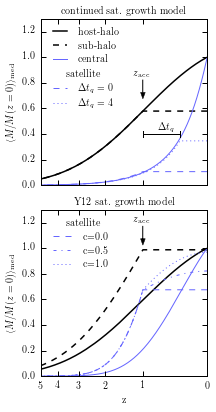

In [49]:
"""
combine these figures into a single two panel figure
"""

#get four halo growth histories
p = MAH(cosmo)
mhalo_history_1, z_halo = p.mah(10**11.0, 0.0)
mhalo_history_2, z_halo = p.mah(10**11.0, 1.0)
mhalo_history_1 = np.log10(10**mhalo_history_1*1.0)
mhalo_history_2 = np.log10(10**mhalo_history_2*0.96)
z = z_halo
a = 1.0/(1.0+z)

#host halo history
mhost_history_1 = mhalo_history_2

#subhistory 1
mask = (z < 1.0)
i = find_nearest(z,1.0)
msub_history_1_1 = np.copy(mhalo_history_2)
msub_history_1_1[0][mask] = msub_history_1_1[0][i]
z_sat_1_1 = np.copy(z)
z_sat_1_1[mask] = z_sat_1_1[i]
a_sat_1_1 = 1.0/(1.0+z_sat_1_1)

#subhistory 2
mask = (z < 0.342)
i = find_nearest(z,0.342)
msub_history_1_2 = np.copy(mhalo_history_2)
msub_history_1_2[0][mask] = msub_history_1_2[0][i]
z_sat_1_2 = np.copy(z)
z_sat_1_2[mask] = z_sat_1_2[i]
a_sat_1_2 = 1.0/(1.0+z_sat_1_2)

mask = (z < 1.0)
i = find_nearest(z,1.0)
mhost_history_2 = mhalo_history_1
msub_history_2 = np.copy(mhalo_history_2)
msub_history_2[0][mask] = msub_history_2[0][i]
z_sat_2_1 = np.copy(z)
z_sat_2_1[mask] = z_sat_2_1[i]
a_sat_2_1 = 1.0/(1.0+z_sat_2_1)


#M13 w/ sat growth
mcen_history_1 = composite_model_3a.mean_stellar_mass(prim_haloprop = 10**mhost_history_1,
                                                     halo_acc_scale = a, redshift=z)
msat_history_1_1 = composite_model_3a.mean_stellar_mass(prim_haloprop = 10**msub_history_1_1,
                                                       halo_acc_scale = a_sat_1_1, redshift=1.0/a_sat_1_1-1)
msat_history_1_2 = composite_model_3a.mean_stellar_mass(prim_haloprop = 10**msub_history_1_2,
                                                       halo_acc_scale = a_sat_1_2, redshift=1.0/a_sat_1_2-1)

#Y12 growth histories
mcen_history_2 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**mhost_history_2,
                                                     halo_acc_scale = a, redshift=z_galaxy)
composite_model_4.param_dict['c'] =  0.0
msat_history_2_1 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history_2,
                                                       halo_acc_scale = a_sat_2_1, redshift=z)
composite_model_4.param_dict['c'] =  0.5
msat_history_2_2 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history_2,
                                                       halo_acc_scale = a_sat_2_1, redshift=z)
composite_model_4.param_dict['c'] =  1.0
msat_history_2_3 = composite_model_4.mean_stellar_mass(prim_haloprop = 10**msub_history_2,
                                                       halo_acc_scale = a_sat_2_1, redshift=z)



fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.3, 6.2))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.9, hspace=0.15)

#top panel
ax = axes[0]
#host-halo
p1, = ax.plot(1+z_halo, 10**mhost_history_1[0]/10**mhost_history_1[0][0], color='black', lw=1.5)
#sub-halo
p2, = ax.plot(1+z_halo, 10**msub_history_1_1[0]/10**mhost_history_1[0][0], '--', color='black', lw=1.5)
#central growth histories
p3, = ax.plot(1+z_halo, mcen_history_1[0]/mcen_history_1[0][0], color='#6666ff')
#satellite growth histories
p0, = ax.plot((1+z_halo), msat_history_1[0]/mcen_history_1[0][0], '-',color='white', alpha=0.0) #dummy
p4, = ax.plot((1+z_halo), msat_history_1_1[0]/mcen_history_1[0][0]*1.07, '--',color='#6666ff')
p5, = ax.plot((1+z_halo), msat_history_1_2[0]/mcen_history_1[0][0]*0.95, ':',color='#6666ff')
ax.text(2.22,0.85,r'$z_{\rm acc}$', fontsize=10)
ax.arrow(2,0.825,dx=0.0,dy=-0.1, head_width=0.1, head_length=0.05, lw=0.5, color='black')
ax.plot([1+1.0,1+0.342],[0.4,0.4],'-',color='black')
ax.plot([1+1.0,1+1.0],[0.4-0.025,0.4+0.025],'-',color='black')
ax.plot([1+0.342,1+0.342],[0.4-0.025,0.4+0.025],'-',color='black')
ax.text(1+0.7,0.43,r'$\Delta t_{q}$')
ax.set_xlim([6,1])
ax.set_ylim([0,1.3])
ax.set_xscale('log')
#ax.set_xlabel('z')
ax.set_xticks([6, 5, 4, 3, 2, 1])
ax.set_xticklabels(['5','4','3','2','1','0'])

#add legend
ax.legend((p1,p2, p3, p0, p4, p5),('host-halo','sub-halo', 'central','', r'$\Delta t_{q}=0$',r'$\Delta t_{q}=4$'),
           fontsize=10, loc='upper left', frameon=False)
ax.set_ylabel(r'$\langle M/M(z=0) \rangle_{\rm med}$')
ax.text(4.6, 0.975-0.125, 'satellite', fontsize=10)
ax.set_title('continued sat. growth model')


#bottom panel
ax=axes[1]
#host halo growth
p1, = ax.plot(1+z, 10**mhost_history_2[0]/10**mhost_history_2[0][0], color='black', lw=1.5)
#sub-halo growth
p2, = ax.plot(1+z, 10**msub_history_2[0]/10**mhost_history_2[0][0], '--', color='black', lw=1.5)
#central galaxy growth
p3, = ax.plot(1+z, mcen_history_2[0]/mcen_history_2[0][0], color='#6666ff')
#satellite growth models
p0, = ax.plot(1+z, msat_history_2_1[0]/mcen_history_2[0][0], '-',color='white', alpha=0.0) #dummy
p4, = ax.plot(1+z, msat_history_2_1[0]/mcen_history_2[0][0], '--',color='#6666ff')
p5, = ax.plot(1+z, msat_history_2_2[0]/mcen_history_2[0][0], '-.',color='#6666ff')
p6, = ax.plot(1+z, msat_history_2_3[0]/mcen_history_2[0][0], ':',color='#6666ff')

#accretion redshift label
ax.text(2.22,0.85+0.35,r'$z_{\rm acc}$', fontsize=10)
ax.arrow(2,0.825+0.35,dx=0.0,dy=-0.1, head_width=0.1, head_length=0.05, lw=0.5, color='black')
ax.set_xlim([6,1])
ax.set_ylim([0,1.3])
ax.set_xscale('log')
ax.set_xlabel('z')
ax.set_ylabel(r'$\langle M/M(z=0) \rangle_{\rm med}$')
ax.set_xticks([6, 5, 4, 3, 2, 1])
ax.set_xticklabels(['5','4','3','2','1','0'])

#add legend
ax.legend((p0,p4,p5,p6),
           ('','c=0.0','c=0.5','c=1.0'),
            frameon = False, fontsize=10, loc='upper left', handlelength=2.5)
ax.text(4.6, 0.975+0.2, 'satellite', fontsize=10)
ax.set_title('Y12 sat. growth model')

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'sat_growth_model_2_panel'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##z=0 Galaxy Clustering

In [50]:
"""
set up function to calculate projected correlation function
in stellar mass bins after placing mock in redshift-space.
"""

from halotools.mock_observables import wp, return_xyz_formatted_array

def calculate_wp(mock, rp_bins,
                 log_mstar_min=10.0, log_mstar_max =10.5,
                 pi_max=40.0, Lbox=250.0):
    """
    Calculate the projected correaltion function
    """
    
    #number of threads to use in wp calculation
    num_threads = 4
    
    #create mask for stellar mass bin
    mask = (mock['stellar_mass']<10.0**log_mstar_max) &\
           (mock['stellar_mass']>10.0**log_mstar_min)
    
    #put galaxy coordinates in mock observables format
    #and apply redshift space distortions
    coords = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'],
                                        velocity = mock['vz'],
                                        velocity_distortion_dimension = 'z',
                                        period = Lbox)
    
    #apply mask for stellar mass bin
    coords = coords[mask]
    
    result = wp(coords,
                rp_bins = rp_bins, pi_max = pi_max,
                period = Lbox,
                do_auto = True, do_cross = False,
                estimator = 'Natural', 
                num_threads = num_threads,
                max_sample_size = int(1e7))
        
    return result

In [118]:
#calculate wp for each model in stellar mass bins

#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_a = np.zeros((3,24))
wp_b = np.zeros((3,24))
wp_c = np.zeros((3,24))

wp_a[0] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_b[0] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)
wp_c[0] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=9.5, log_mstar_max =10.0)

wp_a[1] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_b[1] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)
wp_c[1] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.0, log_mstar_max =10.5)

wp_a[2] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)
wp_b[2] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)
wp_c[2] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                       log_mstar_min=10.5, log_mstar_max =11.0)

In [52]:
#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

#create intterpolation function
from scipy.interpolate import interp1d
f_w_1 = interp1d(wp_sdss_1[0,:],wp_sdss_1[1,:], fill_value="extrapolate")
f_err_1 = interp1d(wp_sdss_1[0,:],err_1, fill_value="extrapolate")
f_w_2 = interp1d(wp_sdss_2[0,:],wp_sdss_2[1,:], fill_value="extrapolate")
f_err_2 = interp1d(wp_sdss_2[0,:],err_2, fill_value="extrapolate")
f_w_3 = interp1d(wp_sdss_3[0,:],wp_sdss_3[1,:], fill_value="extrapolate")
f_err_3 = interp1d(wp_sdss_3[0,:],err_3, fill_value="extrapolate")

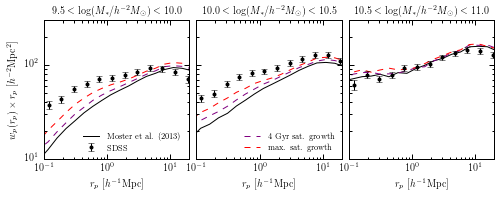

In [119]:
fig, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)
    
ax = axes[0]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p)\times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
    
ax = axes[1]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
    
ax = axes[2]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')

ax = axes[0]
p1, = ax.plot(rp_bin_centers, wp_a[0]*rp_bin_centers, '-', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[0]*rp_bin_centers, '--', color='purple', alpha=1)
p3, = ax.plot(rp_bin_centers, wp_c[0]*rp_bin_centers, '--', color='red', alpha=1)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[1]
p1, = ax.plot(rp_bin_centers, wp_a[1]*rp_bin_centers, '-', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[1]*rp_bin_centers, '--', color='purple', alpha=1)
p3, = ax.plot(rp_bin_centers, wp_c[1]*rp_bin_centers, '--', color='red', alpha=1)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_2*wp_sdss_2[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[2]
p1, = ax.plot(rp_bin_centers, wp_a[2]*rp_bin_centers, '-', color='black', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_b[2]*rp_bin_centers, '--', color='purple', alpha=1)
p3, = ax.plot(rp_bin_centers, wp_c[2]*rp_bin_centers, '--', color='red', alpha=1)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_3*wp_sdss_3[0,:],
                  fmt='o', color='black', ms=4, mec='none')

#add legends
ax = axes[0]
ax.legend((p1,p0),
     ('Moster et al. (2013)','SDSS'),
     frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)


ax = axes[1]
ax.legend((p2,p3),
    ('4 Gyr sat. growth','max. sat. growth'),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'wp_sat_growth_comparison'
fig.savefig(filepath+filename+'.pdf', dpi=300)